In [85]:
# Imports 
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline 

In [86]:
# That Data
df = pd.read_json('../../../Data/data.json')
df.head()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,premium,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA


In [87]:
# Make fraud column 
df['fraud'] = df.acct_type.apply(lambda x: 1 if 'fraud' in x else 0)

In [88]:
df.fraud.value_counts()

0    13044
1     1293
Name: fraud, dtype: int64

In [89]:
# Get columns 
columns = list(df.columns)

# See What they looks like 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   acct_type           14337 non-null  object 
 1   approx_payout_date  14337 non-null  int64  
 2   body_length         14337 non-null  int64  
 3   channels            14337 non-null  int64  
 4   country             14256 non-null  object 
 5   currency            14337 non-null  object 
 6   delivery_method     14321 non-null  float64
 7   description         14337 non-null  object 
 8   email_domain        14337 non-null  object 
 9   event_created       14337 non-null  int64  
 10  event_end           14337 non-null  int64  
 11  event_published     14238 non-null  float64
 12  event_start         14337 non-null  int64  
 13  fb_published        14337 non-null  int64  
 14  gts                 14337 non-null  float64
 15  has_analytics       14337 non-null  int64  
 16  has_

In [90]:
# Desccribe Int variables 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
approx_payout_date,14337.0,1.350933e+09,2.401300e+07,1.171256e+09,1.334221e+09,1.355805e+09,1.370646e+09,1.523488e+09
body_length,14337.0,3.672522e+03,5.758113e+03,0.000000e+00,7.500000e+02,1.990000e+03,4.280000e+03,6.553500e+04
channels,14337.0,6.176676e+00,3.860333e+00,0.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.300000e+01
delivery_method,14321.0,4.395643e-01,5.914866e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
event_created,14337.0,1.345825e+09,2.404107e+07,1.170332e+09,1.329754e+09,1.351043e+09,1.365346e+09,1.382012e+09
event_end,14337.0,1.350501e+09,2.401299e+07,1.170824e+09,1.333789e+09,1.355373e+09,1.370214e+09,1.523056e+09
event_published,14238.0,1.340854e+09,8.750386e+07,0.000000e+00,1.329499e+09,1.351099e+09,1.365478e+09,1.381608e+09
event_start,14337.0,1.350205e+09,2.398787e+07,1.170819e+09,1.333406e+09,1.355000e+09,1.370048e+09,1.418850e+09
fb_published,14337.0,1.274325e-01,3.334685e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
gts,14337.0,2.430231e+03,9.142308e+03,0.000000e+00,1.164100e+02,4.319300e+02,1.547260e+03,3.062939e+05


In [91]:
# Get missing varaiabels 
missing_values = []
for col in columns:
    if df[col].isna().any():
        missing_values.append(col)
        
print(f'Number: {len(missing_values)} \n\nVariables with missing values:\n{missing_values}')

Number: 12 

Variables with missing values:
['country', 'delivery_method', 'event_published', 'has_header', 'org_facebook', 'org_twitter', 'sale_duration', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state']


In [92]:
# get variabels by type 
var_floats = []
var_ints = []
var_objects = []

for col in columns:
    if df[col].dtype == 'int64':
        var_ints.append(col)
    elif df[col].dtype == 'float64':
        var_floats.append(col)
    else:
        var_objects.append(col)

print(f' Floats: {var_floats} \n\n Ints: {var_ints} \n\n Objects: {var_objects}')

 Floats: ['delivery_method', 'event_published', 'gts', 'has_header', 'org_facebook', 'org_twitter', 'sale_duration', 'venue_latitude', 'venue_longitude'] 

 Ints: ['approx_payout_date', 'body_length', 'channels', 'event_created', 'event_end', 'event_start', 'fb_published', 'has_analytics', 'has_logo', 'name_length', 'num_order', 'num_payouts', 'object_id', 'sale_duration2', 'show_map', 'user_age', 'user_created', 'user_type', 'fraud'] 

 Objects: ['acct_type', 'country', 'currency', 'description', 'email_domain', 'listed', 'name', 'org_desc', 'org_name', 'payee_name', 'payout_type', 'previous_payouts', 'ticket_types', 'venue_address', 'venue_country', 'venue_name', 'venue_state']


# Notes 

**Isolation Forest**

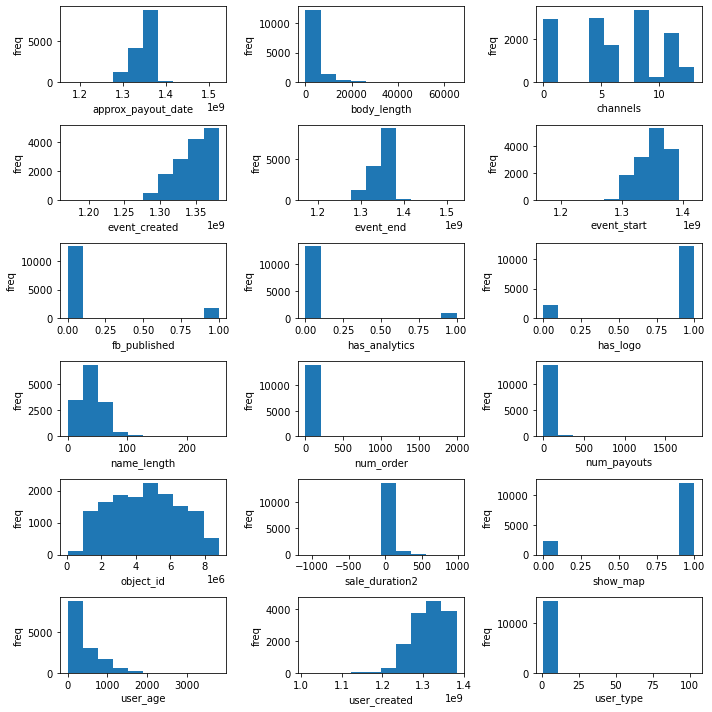

In [93]:
# Show Int data distribution 
def plot(data, vars_, r, c):
    fig, axs = plt.subplots(r, c, figsize = (10,10))

    for i, ax in enumerate(axs.flatten()):
        ax.hist(data[vars_[i]])
        ax.set_xlabel(vars_[i])
        ax.set_ylabel('freq')

    plt.tight_layout()
plot(df, var_ints, 6, 3)

In [94]:
df.user_type.value_counts()

3      7520
1      3738
4      3017
5        59
103       2
2         1
Name: user_type, dtype: int64

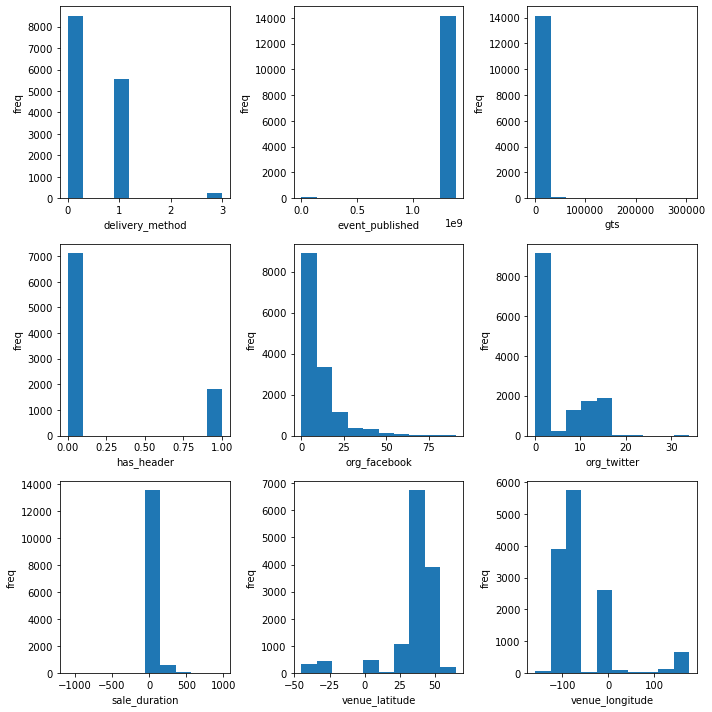

In [95]:
# Show float data distribution 
plot(df, var_floats, 3, 3)

In [96]:
# Peek Object Variables 
for v in var_objects:
    print(f'    {v} \n{df[v].value_counts()} \n\n\n')

    acct_type 
premium             12373
fraudster_event       851
fraudster             437
spammer_limited       218
spammer_warn          144
tos_warn               91
spammer_noinvite       84
tos_lock               77
locked                 54
fraudster_att           5
spammer_web             2
spammer                 1
Name: acct_type, dtype: int64 



    country 
US    9234
GB    2083
CA    1262
AU     742
       316
      ... 
NI       1
CO       1
BB       1
EC       1
IM       1
Name: country, Length: 72, dtype: int64 



    currency 
USD    9696
GBP    2222
CAD    1322
AUD     779
EUR     262
NZD      55
MXN       1
Name: currency, dtype: int64 



    description 
                                                                                                                                                                                                                                                                                                                         

    previous_payouts 
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

    ticket_types 
[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           88
[{'event_id': 5710994, 'cost': 25.0, 'availability': 1, 'quantity_total': 400, 'quantity_sold': 89}, {'event_id': 5710994, 'cost': 30.0, 'availability': 1, 'quantity_total': 100, 'quantity_sold': 4}, {'event_id': 5710994, 'cost': 0.0, 'availability': 1, 'quantity_total': 100, 'quantity_sold': 0}]                                                                                                                                                                                             

In [97]:
# Return all events with no payouts 
nopayouts_mask = df.previous_payouts.apply(lambda x: True if len(x) <= 0 else False)
df[nopayouts_mask]

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,fraud
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL,1
26,fraudster,1299607200,870,11,US,USD,0.0,"<h1 class=""post"">Welcome</h1>\r\n<p> </p>\r\n<...",hotmail.com,1299171416,...,42,1295576777,3,400 Fifth Avenue,US,40.750228,-73.983714,The Setai,NY,1
54,fraudster,1312761600,3081,11,,GBP,0.0,"<h3><strong><strong><span style=""font-family: ...",hotmail.co.uk,1311717051,...,0,1311717050,1,Hammersmith Road,,0.000000,0.000000,Olympia Exhibition Hall,,1
70,fraudster,1322895600,0,13,US,USD,0.0,,yahoo.com,1316795942,...,0,1316795486,1,5801 Security Blvd,US,39.308752,-76.716174,,MD,1
128,fraudster,1331953200,1045,0,GB,GBP,0.0,"<p><span style=""font-size: medium; color: #ff0...",ymail.com,1330545234,...,0,1330544678,1,67 Old Gate Road,GB,52.740168,-1.043989,Hill Top Caravan Park,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14316,fraudster_event,1360310400,3276,4,GB,GBP,0.0,"<div id=""yui_3_7_2_16_1358948795407_159"" style...",hotmail.co.uk,1358948648,...,0,1358948648,1,Sagar Street,,53.523896,-2.276553,Al Maidah Banquet Hall and Restaurant,,1
14318,fraudster_event,1359784800,448,0,US,USD,0.0,<p>Help us produce this incredible experience....,gmail.com,1358975278,...,0,1358975276,1,94 West Houston Street,US,40.727236,-74.000090,Madame X,NY,1
14325,fraudster_event,1360049400,996,0,US,USD,0.0,"<p><span style=""font-size: medium;""><strong>Yo...",gmail.com,1359415821,...,0,1359415820,1,3280 Peachtree Rd NE,US,33.844403,-84.370374,AQUANOX,GA,1
14332,fraudster_event,1361689200,667,0,US,USD,0.0,<p>Celebrates this wonderful holiday with the ...,yahoo.com,1360297993,...,0,1360297993,1,6100 North Charles Street,US,39.373780,-76.629921,Elkridge Club,MD,1


In [98]:
# No pay out that are farud
df2 = df[~nopayouts_mask]

In [99]:
df.fraud.sum()

1293

In [100]:
df2_fraud = df2[df2.fraud == 1]

In [101]:
df2_fraud

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,fraud
51,fraudster_event,1329465600,536,6,US,USD,0.0,"<p><span style=""font-size: x-large;"">Okay ever...",cox.net,1317544696,...,77,1310957994,1,404 euclid ave,US,32.702072,-117.085088,The Jacobs Center at Market Creek,CA,1
130,fraudster,1331535300,108,6,US,USD,0.0,<p>TODAY'S LIVE Conference Call is scheduled f...,gmail.com,1331041029,...,306,1304639602,3,,None,NaN,NaN,None,None,1
131,fraudster,1331964000,1529,11,US,USD,0.0,<p> ALL PROCEEDS WILL GO TOWARD BETTERING OUR ...,yahoo.com,1331162405,...,0,1331161913,1,900 EAST PRINCETON ST.,US,28.570472,-81.367605,The Mennello Museum of American Art,FL,1
140,fraudster,1333519200,108,6,US,USD,0.0,<p>TODAY'S LIVE Conference Call is scheduled f...,gmail.com,1332979005,...,328,1304639602,3,,None,NaN,NaN,None,None,1
149,fraudster_event,1335796200,1946,5,GB,GBP,0.0,"<h1><span style=""font-size: x-large;"">You've d...",zumba-perth.com,1335366629,...,0,1335364397,1,St Catherine's Retail Park,GB,56.399777,-3.438740,,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,fraudster,1301900400,1805,8,US,USD,0.0,"<p><font size=""3"">This Is One Of My<strong> La...",gmail.com,1300895414,...,250,1279317861,3,10307 N. Mall Dr.,US,30.379213,-91.065613,Courtyard Baton Rouge Siegen Lane,LA,1
14054,fraudster,1312952400,452,5,US,USD,0.0,"<p><span class=""vevent""><span class=""descripti...",gmail.com,1312323701,...,31,1309600045,1,46900 Mission Boulevard,US,37.487426,-121.931939,,,1
14125,fraudster,1331251200,2445,11,US,USD,0.0,<p>The time has come back round.. Come celebra...,gmail.com,1330711807,...,0,1330711505,3,7720 Lakeside Woods Dr,US,28.628014,-81.424567,,FL,1
14140,fraudster_event,1334210400,102,5,CA,CAD,0.0,<p>Up-Top Communications Presents The Spring C...,yahoo.ca,1333379197,...,0,1333379193,1,17 Vinyl Court,US,43.767592,-79.567586,Platinum Convention Centre,ON,1


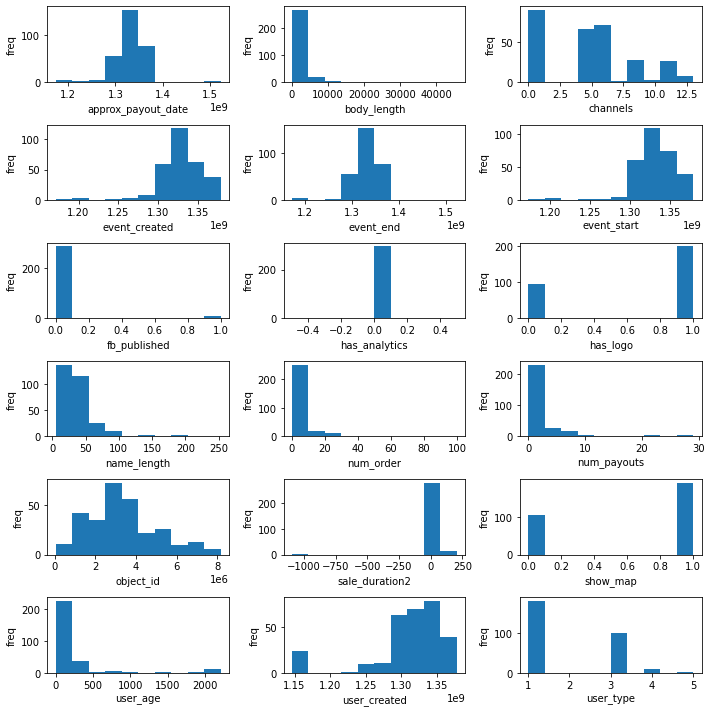

In [102]:
plot(df2_fraud, var_ints, 6, 3)

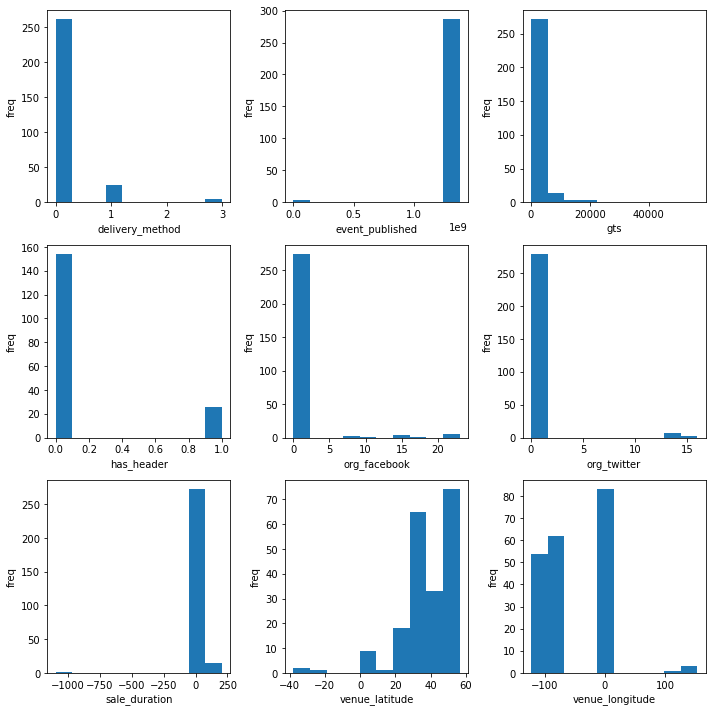

In [103]:
plot(df2_fraud, var_floats, 3, 3)

In [104]:
# Peek Object Variables 
for v in var_objects:
    print(f'    {v} \n{df2_fraud[v].value_counts()} \n\n\n')
    
# delivery_method     991 non-null    float64
# has_header          339 non-null    float64
# 42  venue_name          203 non-null    object
# 25  org_facebook        289 non-null    float64
# 31  sale_duration       288 non-null    float64

    acct_type 
fraudster          169
fraudster_event    125
fraudster_att        1
Name: acct_type, dtype: int64 



    country 
US    174
GB     80
CA     15
        6
AU      5
CI      4
A1      4
MA      2
VN      2
CH      1
DE      1
NZ      1
Name: country, dtype: int64 



    currency 
USD    182
GBP     92
CAD     12
EUR      6
AUD      3
Name: currency, dtype: int64 



    description 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [105]:
# Peek Object Variables 
for v in ['payee_name', 'org_name']:
    print(f'    {v} \n{df[v].value_counts()} \n\n\n')

    payee_name 
                                                                11160
Reel Link Films                                                    35
SkyNet Media LLC                                                   22
Busboys and Poets,                                                 21
Seneca Lake Winery Association                                     19
                                                                ...  
River Parks Foundation                                              1
Networking For Your Success                                         1
Greater Columbus Convention Center                                  1
Historic Preservation Commission of South Bend & St. Joseph         1
Second Sole Racing                                                  1
Name: payee_name, Length: 2481, dtype: int64 



    org_name 
                                             1462
Gametightny.com                                44
ATD - ImprovBoston                             41
G

In [106]:
df.fraud.sum()

1293

In [107]:
# Check to see if payee is a real person 
df['missing_payee'] = df.payee_name.apply(lambda x: 1 if len(x) < 3 else 0)

## ------------ Fraud Payee and Pay to

In [108]:
# Missing payee
mask_none_missing_payee = df['missing_payee'] == 0

In [109]:
# None Missing payee that are fraud 
temp = df[(df['missing_payee'] == 0) & (df['fraud'] == 1)]

In [110]:
# get all the people who did not pay out to some one but was fraud 
mask = temp.previous_payouts.apply(lambda x: True if len(x) <= 0 else False)

In [111]:
temp.loc[~mask, ['payee_name']]

,payee_name
51,robert carter
1008,Steven Kadlec
4588,C.Cornish
5151,Annie Zurth
7011,Steven Kadlec
7554,Global Gas Card
9564,Royal Princesses and Knights
10000,Jason Phillips
10608,C.Cornish
11504,PARTY STARZ ENT INC


In [112]:
temp[~mask].previous_payouts[11504]

[{'name': 'PARTY STARZ ENT INC',
  'created': '2010-07-08 01:10:16',
  'country': 'US',
  'amount': 20.0,
  'state': 'FL',
  'address': '775 NE 180 TH street',
  'uid': 2818575,
  'event': 578389,
  'zip_code': '33162'},
 {'name': 'Jason Phillips',
  'created': '2010-07-15 01:10:36',
  'country': 'US',
  'amount': 460.0,
  'state': 'FL',
  'address': '775 NE 180th Street',
  'uid': 2818575,
  'event': 751295,
  'zip_code': '33162'},
 {'name': '',
  'created': '2011-11-27 03:11:41',
  'country': 'US',
  'amount': 1550.0,
  'state': '',
  'address': '',
  'uid': 2818575,
  'event': 1104127,
  'zip_code': ''},
 {'name': '',
  'created': '2012-01-19 03:11:43',
  'country': 'US',
  'amount': 1100.0,
  'state': '',
  'address': '',
  'uid': 2818575,
  'event': 2687179,
  'zip_code': ''},
 {'name': '',
  'created': '2012-05-18 03:14:00',
  'country': 'US',
  'amount': 20.0,
  'state': '',
  'address': '',
  'uid': 2818575,
  'event': 3494235,
  'zip_code': ''},
 {'name': '',
  'created': '201

# ---- Important fraud factors 
1. No previous pay outs 
2. Pay out is to no one 
3. Payout is to payee



mask = df.previous_payouts.apply(lambda x: True if len(x) <= 0 else False)
df[mask]

In [113]:
def not_premium(x):
    return 1 if x.lower() != 'premium' else 0

def no_previous_payout(x):
    return 1 if len(x) <= 0 else 0

def payout_name_flag(x):
    for d in x:
        if len(d['name']) > 3:
            return 1
    return 0

def payout_toself(payee, payouts):
    if payee == '': return 1
    for pay in payouts:
        if payee.lower() in pay['name'].lower():
            return 1
    return 0

In [114]:
df

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,fraud,missing_payee
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL,1,1
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC,0,0
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA,0,0
3,premium,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,1283870102,3,,None,NaN,NaN,None,None,0,1
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,fraudster_event,1361689200,667,0,US,USD,0.0,<p>Celebrates this wonderful holiday with the ...,yahoo.com,1360297993,...,1360297993,1,6100 North Charles Street,US,39.373780,-76.629921,Elkridge Club,MD,1,1
14333,premium,1365566400,5812,5,US,USD,1.0,"<table style=""width: 600px;"" border=""0"" cellsp...",me.com,1360367042,...,1241625346,4,1775 E Mission Bay Dr,US,32.778906,-117.209791,Hilton San Diego Resort and Spa (Hilton Missio...,CA,0,0
14334,premium,1368781200,557,13,,USD,0.0,<p>What a way to start off your Mother's Day l...,yahoo.com,1360600330,...,1353386971,4,5991 Bullard Road,US,30.041819,-89.957130,Fleur De Lis Ballroom NUMBER 2,LA,0,1
14335,tos_warn,1361361600,10873,8,US,USD,0.0,"<p style=""font-family: 'Helvetica Neue', Helve...",velvetlist.com,1360376285,...,1290204991,3,2297 Cedar Ave,US,40.862283,-73.911363,Salsa con fuego,NY,0,1


In [84]:
df = pd.DataFrame(temp)
df.head()

""


In [66]:
def get_crosstab(X, y, model_type):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
    model = model_type
    model.fit(Xtrain, ytrain)
    print(model.predict_proba(Xtest))
    predicted = model.predict(Xtest)
    actual = ytest
    crosstab = pd.crosstab(ytest, model.predict(Xtest), rownames=['actual'], colnames=['predicted'])
    return model, crosstab

# ----- Grid Search 

In [67]:
rfc = RandomForestClassifier(random_state=0)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop('target', axis = 1), df['target'])

In [68]:
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv= 5)
CV_rfc.fit(Xtrain, ytrain)
params = CV_rfc.best_params_
params

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [69]:
params = CV_rfc.best_params_
params

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 200}

In [80]:
get_crosstab(df.drop('target', axis = 1), df['target'], RandomForestClassifier(**params))

[[0.04051674 0.95948326]
 [0.96116233 0.03883767]
 [0.97949803 0.02050197]
 ...
 [0.97949803 0.02050197]
 [0.97949803 0.02050197]
 [0.99296543 0.00703457]]


(RandomForestClassifier(max_depth=4, n_estimators=200),
 predicted     0    1
 actual              
 0          3272   24
 1            69  220)

In [55]:
77 / (77 + 257)

0.23053892215568864

### Columns in API 
> 'body_length', 'channels', 'country', 'currency', 'delivery_method',
   'description', 'email_domain', 'event_created', 'event_end',
   'event_published', 'event_start', 'fb_published', 'has_analytics',
   'has_header', 'has_logo', 'listed', 'name', 'name_length', 'object_id',
   'org_desc', 'org_facebook', 'org_name', 'org_twitter', 'payee_name',
   'payout_type', 'previous_payouts', 'sale_duration', 'show_map',
   'ticket_types', 'user_age', 'user_created', 'user_type',
   'venue_address', 'venue_country', 'venue_latitude', 'venue_longitude',
   'venue_name', 'venue_state', 'sequence_number'